In [437]:
# load data from the csv file
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import Dataset
from torchvision import transforms
from torchvision.models import mobilenet_v2
from tqdm import tqdm
import torch




import seaborn as sns
import random
random_seed = 33  # you can choose any number

# Set the seed for Python's random module
random.seed(random_seed)

# Set the seed for NumPy's random module
np.random.seed(random_seed)

# Set the seed for PyTorch's random module
torch.manual_seed(random_seed)

def load_labels(label_path):
    import pandas as pd
    
    data_labels_paths = pd.read_csv(label_path)
    # Check input folder for valid images
    valid_extensions = [".jpg", ".jpeg", ".png", ".bmp", ".gif"]
    data_labels = pd.DataFrame(columns = ['image_path', 'source','classification','is_cropped','image_id','image'])
    data_labels_paths = data_labels_paths.to_dict('records')
    for data_labels_path in data_labels_paths:
        for image_file in os.listdir(data_labels_path['image_path']):
            # Get the file extension
            _, extension = os.path.splitext(image_file)
            
            # If the file is an image, process it
            if extension.lower() in valid_extensions:
                new_row = {'image_path': data_labels_path['image_path'], 'source': data_labels_path['source'], 'classification': data_labels_path['classification'], 'is_cropped': data_labels_path['is_cropped'] == 'yes', 'image_id': image_file, 'image': data_labels_path['image_path'] + image_file}
                data_labels.loc[len(data_labels)] = new_row
    
    data_labels['label'] = (data_labels['classification'] == 'tesla_car').astype(int)
    data_labels['is_tesla_text'] = ['An aerial view of a Tesla car' if x == 1 else 'An arial view of a car of unknown maker' for x in data_labels['label']]
    data_labels['task_text'] = 'car. tesla car'
    data_labels['name'] = ['Tesla' if x == 1 else 'Not Tesla' for x in data_labels['label']]
    data_labels["idx"] = data_labels.index
    return data_labels

data_labels = load_labels('../data/labels/car_labels.csv')

In [438]:
data_labels[]

,image_path,source,classification,is_cropped,image_id,image,label,is_tesla_text,task_text,name,idx
0,/Users/jkerlin/PycharmProjects/satana/data/ima...,cars_whole_foods,tesla_car,True,Whole Foods 911 Soquel Ave_crop_12.jpg,/Users/jkerlin/PycharmProjects/satana/data/ima...,1,An aerial view of a Tesla car,car. tesla car,Tesla,0
1,/Users/jkerlin/PycharmProjects/satana/data/ima...,cars_whole_foods,tesla_car,True,Whole Foods 911 Soquel Ave_crop_13.jpg,/Users/jkerlin/PycharmProjects/satana/data/ima...,1,An aerial view of a Tesla car,car. tesla car,Tesla,1
2,/Users/jkerlin/PycharmProjects/satana/data/ima...,cars_whole_foods,tesla_car,True,"Whole Foods, 777 Alameda_crop_20.jpg",/Users/jkerlin/PycharmProjects/satana/data/ima...,1,An aerial view of a Tesla car,car. tesla car,Tesla,2
3,/Users/jkerlin/PycharmProjects/satana/data/ima...,cars_whole_foods,tesla_car,True,Whole Foods 911 Soquel Ave_crop_10.jpg,/Users/jkerlin/PycharmProjects/satana/data/ima...,1,An aerial view of a Tesla car,car. tesla car,Tesla,3
4,/Users/jkerlin/PycharmProjects/satana/data/ima...,cars_whole_foods,tesla_car,True,Whole Foods 911 Soquel Ave_crop_15.jpg,/Users/jkerlin/PycharmProjects/satana/data/ima...,1,An aerial view of a Tesla car,car. tesla car,Tesla,4
...,...,...,...,...,...,...,...,...,...,...,...
923,/Users/jkerlin/PycharmProjects/satana/data/ima...,gold_standard,not_tesla_car,True,mini15_crop_1.jpg,/Users/jkerlin/PycharmProjects/satana/data/ima...,0,An arial view of a car of unknown maker,car. tesla car,Not Tesla,923
924,/Users/jkerlin/PycharmProjects/satana/data/ima...,gold_standard,not_tesla_car,True,mercedes25_crop_3.jpg,/Users/jkerlin/PycharmProjects/satana/data/ima...,0,An arial view of a car of unknown maker,car. tesla car,Not Tesla,924
925,/Users/jkerlin/PycharmProjects/satana/data/ima...,gold_standard,not_tesla_car,True,toyota16_crop_0.jpg,/Users/jkerlin/PycharmProjects/satana/data/ima...,0,An arial view of a car of unknown maker,car. tesla car,Not Tesla,925
926,/Users/jkerlin/PycharmProjects/satana/data/ima...,gold_standard,not_tesla_car,True,rangerover1_crop_2.jpg,/Users/jkerlin/PycharmProjects/satana/data/ima...,0,An arial view of a car of unknown maker,car. tesla car,Not Tesla,926


In [439]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from datasets import Dataset, Features, Audio, Image, ClassLabel
from torchvision.transforms import RandomResizedCrop,Resize, Compose, Normalize, ToTensor, ToPILImage
import evaluate
# Assuming `data_labels` is a pandas DataFrame
ds = (Dataset.from_pandas(data_labels)
      .cast_column("image", Image())
      .cast_column("label", ClassLabel(num_classes=2, names=["Not Tesla", "Tesla"]))
      )
ds = ds.remove_columns([col for col in ds.features if col not in ['idx','image','label','task_text','source']])
# def transforms(items):
#     items["pixel_values"] = [image.convert("RGB") for image in items["image"]]
#     return items
# 
# ds = ds.map(transforms, remove_columns="image", batched=True)


Casting the dataset:   0%|          | 0/928 [00:00<?, ? examples/s]

/Users/jkerlin/PycharmProjects/satana/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [440]:
ds

DatasetDict({
    train: Dataset({
        features: ['source', 'image', 'label', 'task_text', 'idx'],
        num_rows: 649
    })
    test: Dataset({
        features: ['source', 'image', 'label', 'task_text', 'idx'],
        num_rows: 279
    })
})

In [441]:
[x["source"] for x in ds_gold]

['gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard',
 'gold_standard']

In [442]:
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
training_args = TrainingArguments(
    output_dir="../data/models/tesla_model/" + model_id + now,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False
)

In [443]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=ds["train"],
    eval_dataset=ds["test"] ,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

In [444]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.411900,0.393870,0.885305
1,0.262300,0.312365,0.885305
2,0.196200,0.268704,0.885305
4,0.073000,0.205624,0.913978
5,0.101000,0.185806,0.935484
6,0.073600,0.178851,0.939068
8,0.088500,0.165805,0.942652
9,0.066800,0.164848,0.942652


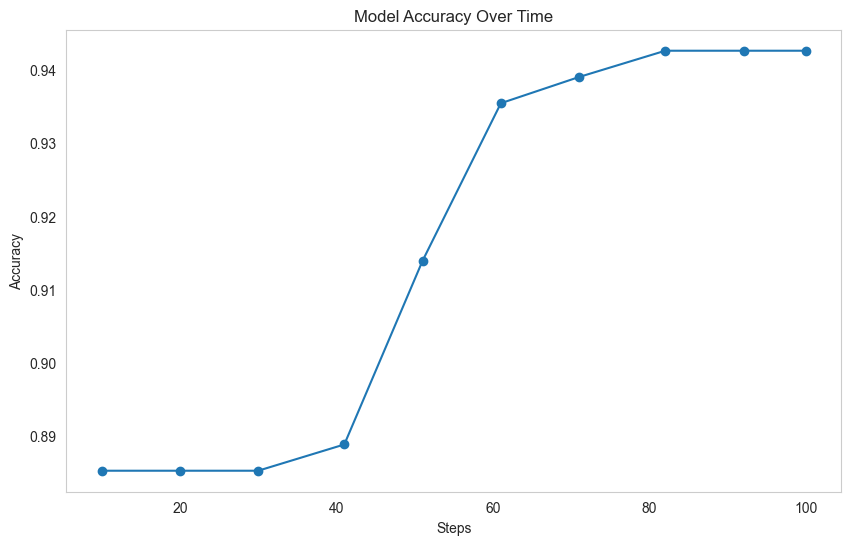

In [445]:
import matplotlib.pyplot as plt

# Retrieve the log history
log_history = trainer.state.log_history

# Extract the accuracy values and the corresponding steps
steps = [entry['step'] for entry in log_history if 'eval_accuracy' in entry]
accuracy_over_steps = [entry['eval_accuracy'] for entry in log_history if 'eval_accuracy' in entry]

# Plot the accuracy values
plt.figure(figsize=(10, 6))
plt.plot(steps, accuracy_over_steps, marker='o')
plt.title('Model Accuracy Over Time')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

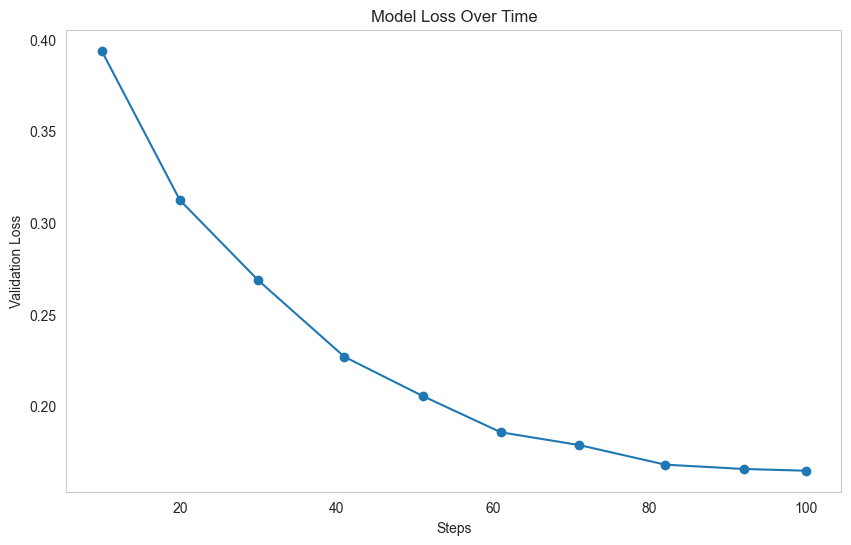

In [446]:
# Extract the accuracy values and the corresponding steps
steps = [entry['step'] for entry in log_history if 'eval_accuracy' in entry]
accuracy_over_steps = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]

# Plot the accuracy values
plt.figure(figsize=(10, 6))
plt.plot(steps, accuracy_over_steps, marker='o')
plt.title('Model Loss Over Time')
plt.xlabel('Steps')
plt.ylabel('Validation Loss')
plt.grid()
plt.show()

In [447]:
log_history

[{'loss': 0.6696,
  'grad_norm': 1.8197262287139893,
  'learning_rate': 5e-06,
  'epoch': 0.0975609756097561,
  'step': 1},
 {'loss': 0.6834,
  'grad_norm': 1.7628368139266968,
  'learning_rate': 1e-05,
  'epoch': 0.1951219512195122,
  'step': 2},
 {'loss': 0.665,
  'grad_norm': 1.844310998916626,
  'learning_rate': 1.5e-05,
  'epoch': 0.2926829268292683,
  'step': 3},
 {'loss': 0.6425,
  'grad_norm': 1.8314082622528076,
  'learning_rate': 2e-05,
  'epoch': 0.3902439024390244,
  'step': 4},
 {'loss': 0.5953,
  'grad_norm': 1.7833547592163086,
  'learning_rate': 2.5e-05,
  'epoch': 0.4878048780487805,
  'step': 5},
 {'loss': 0.5693,
  'grad_norm': 1.7294135093688965,
  'learning_rate': 3e-05,
  'epoch': 0.5853658536585366,
  'step': 6},
 {'loss': 0.5365,
  'grad_norm': 1.3580341339111328,
  'learning_rate': 3.5e-05,
  'epoch': 0.6829268292682927,
  'step': 7},
 {'loss': 0.4851,
  'grad_norm': 1.4331212043762207,
  'learning_rate': 4e-05,
  'epoch': 0.7804878048780488,
  'step': 8},
 {'l

In [448]:
train_results

TrainOutput(global_step=100, training_loss=0.18411710381507873, metrics={'train_runtime': 339.2253, 'train_samples_per_second': 19.132, 'train_steps_per_second': 0.295, 'total_flos': 4.910667381876695e+17, 'train_loss': 0.18411710381507873, 'epoch': 9.75609756097561})

In [449]:
ds["train"][0]

{'source': 'cars_whole_foods',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=79x101>,
 'label': 0,
 'task_text': 'car. tesla car',
 'idx': 472,
 'pixel_values': tensor([[[ 0.3176,  0.3176,  0.3255,  ...,  0.2314,  0.2314,  0.2314],
          [ 0.3176,  0.3176,  0.3255,  ...,  0.2314,  0.2314,  0.2314],
          [ 0.3098,  0.3098,  0.3176,  ...,  0.2314,  0.2314,  0.2314],
          ...,
          [-0.7804, -0.7804, -0.7804,  ..., -0.4275, -0.4196, -0.4196],
          [-0.7804, -0.7804, -0.7804,  ..., -0.4196, -0.4118, -0.4118],
          [-0.7804, -0.7804, -0.7804,  ..., -0.4196, -0.4118, -0.4118]],
 
         [[ 0.3647,  0.3647,  0.3725,  ...,  0.2627,  0.2627,  0.2627],
          [ 0.3647,  0.3647,  0.3725,  ...,  0.2627,  0.2627,  0.2627],
          [ 0.3569,  0.3569,  0.3647,  ...,  0.2627,  0.2627,  0.2627],
          ...,
          [-0.6078, -0.6078, -0.6078,  ..., -0.3569, -0.3490, -0.3490],
          [-0.6078, -0.6078, -0.6078,  ..., -0.3490, -0.3412, -0.341

In [450]:
dir(ds["train"])

['_TF_DATASET_REFS',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getitems__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_local_temp_path',
 '_check_index_is_initialized',
 '_data',
 '_estimate_nbytes',
 '_fingerprint',
 '_format_columns',
 '_format_kwargs',
 '_format_type',
 '_generate_tables_from_cache_file',
 '_generate_tables_from_shards',
 '_get_cache_file_path',
 '_get_output_signature',
 '_getitem',
 '_indexes',
 '_indices',
 '_info',
 '_map_single',
 '_new_dataset_with_indices',
 '_output_all_columns',
 '_push_parquet_shards_to_hub',
 '_save_to_disk_single',


In [451]:
ds["test"][0]['idx']

840

In [154]:

from torchvision.transforms import RandomResizedCrop,Resize, Compose, Normalize, ToTensor, ToPILImage

In [452]:
image_set = 'test'
predictions = trainer.predict(ds[image_set])
pred = pd.DataFrame()
pred['predictions'] = np.argmax(predictions.predictions, axis=1)
pred['pred0'] = predictions.predictions[:,0]
pred['pred1'] = predictions.predictions[:,1]
pred['pred_diff'] = pred['pred1'] - pred['pred0']
pred['labels'] = predictions.label_ids
pred['test_to_label_index'] = [ds[image_set][x]['idx'] for x in range(0,len(ds[image_set]))]

pred['result'] = ''
pred.loc[(pred['predictions'] == 1) & (pred['labels'] == 1), 'result'] = 'hit'
pred.loc[(pred['predictions'] == 0) & (pred['labels'] == 0), 'result'] = 'correct rejection'
pred.loc[(pred['predictions'] == 1) & (pred['labels'] == 0), 'result'] = 'false alarm'
pred.loc[(pred['predictions'] == 0) & (pred['labels'] == 1), 'result'] = 'miss'

# Group images based on the result
grouped_images = pred.groupby('result')

# Now you can access the images for each group
hits = grouped_images.get_group('hit')
misses = grouped_images.get_group('miss')
false_alarms = grouped_images.get_group('false alarm')
correct_rejections = grouped_images.get_group('correct rejection')

In [453]:
predictions

PredictionOutput(predictions=array([[ 1.9400308 , -1.865957  ],
       [ 1.5742348 , -1.5462191 ],
       [ 0.34081808, -0.16613773],
       [ 1.7734269 , -1.6707712 ],
       [ 1.8989924 , -1.96252   ],
       [-0.10225409,  0.27985477],
       [-0.22857954,  0.43110645],
       [ 1.5264605 , -1.566817  ],
       [ 1.3916327 , -1.2410008 ],
       [ 1.9404975 , -2.0406215 ],
       [ 1.8200647 , -1.864512  ],
       [ 1.6001397 , -1.6556243 ],
       [ 1.6985471 , -1.6382772 ],
       [ 1.9467216 , -1.9891899 ],
       [ 1.6395603 , -1.629332  ],
       [ 1.7984716 , -1.891298  ],
       [-0.4089671 ,  0.67461556],
       [ 1.9772447 , -2.0262578 ],
       [ 1.8188101 , -2.1006415 ],
       [ 1.7606114 , -1.8273364 ],
       [ 1.6416146 , -1.6834376 ],
       [ 1.9059001 , -1.9589976 ],
       [ 0.26246452, -0.18254288],
       [ 1.8912865 , -2.0347834 ],
       [ 1.9040087 , -1.9521028 ],
       [ 1.855475  , -1.8725833 ],
       [ 1.9742581 , -2.0620446 ],
       [ 1.8823341 , -2.04

In [454]:
import cv2
from PIL import ImageOps
import matplotlib.colors

def denormalize(tensor, mean, std):
    """Denormalize a tensor"""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


def min_max_norm(x):
    return (x - x.min()) / (x.max() - x.min())

def display_images(prediction_groups, group_labels, num_images_per_group=4):
    plt.figure(figsize=(20, 20))
    for group_num in range(0, len(prediction_groups)):
        for i in range(0, np.min([num_images_per_group, len(prediction_groups[group_num])])):
            
            tensor_image = ds["test"][int(prediction_groups[group_num].index[i])]["pixel_values"]
            #img = tensor_image.type(torch.uint8).squeeze(0)
            img = np.transpose(denormalize(tensor_image,mean=image_processor.image_mean, std=image_processor.image_std).numpy(),(1,2,0))
            #img = np.transpose(tensor_image.numpy(),(1,2,0))
            #img = tensor_image.numpy()
            #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            plt.subplot(len(prediction_groups),num_images_per_group, group_num*num_images_per_group + i + 1)
            plt.tight_layout()
            plt.imshow(img)
            plt.axis('off')
            plt.title(group_labels[group_num])

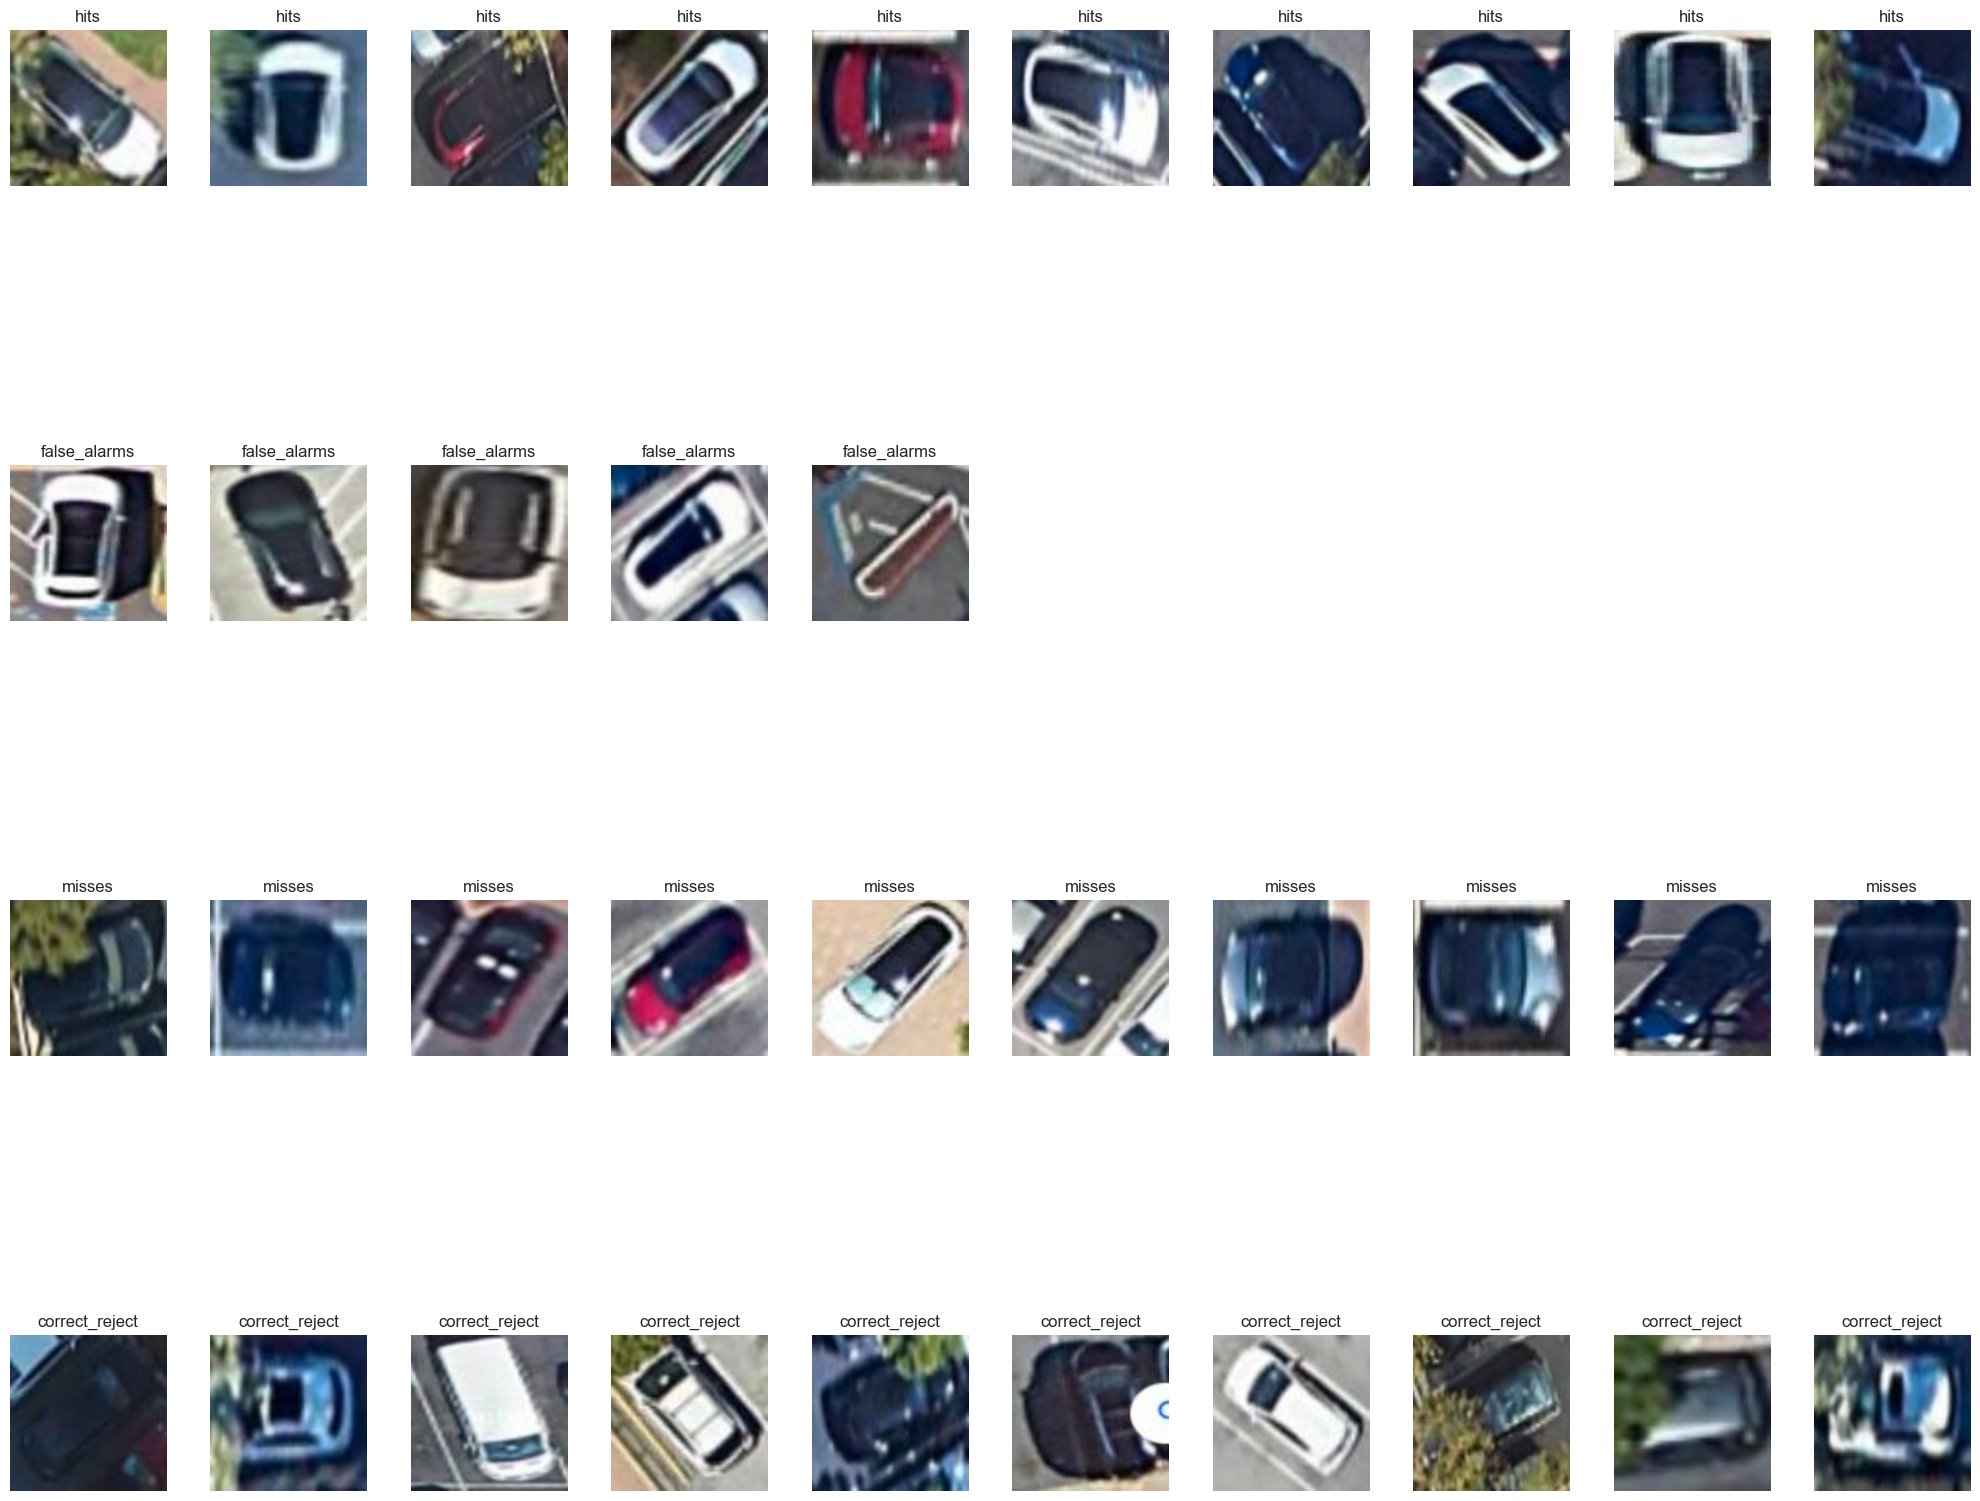

In [455]:
display_images([hits, false_alarms,misses,correct_rejections],['hits', 'false_alarms','misses','correct_reject'], num_images_per_group=10)

In [323]:
np.min([4, len(hits)])

4

In [457]:
len(misses)

11

In [322]:
len(hits)

23

In [ ]:
tensor_image = ds["test"][int(prediction_group.index[i])]["pixel_values"]
#img = tensor_image.type(torch.uint8).squeeze(0)
img = np.transpose(denormalize(tensor_image,mean=image_processor.image_mean, std=image_processor.image_std).numpy(),(1,2,0))
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.imshow(img, norm=matplotlib.colors.Normalize(vmin=0, vmax=255))


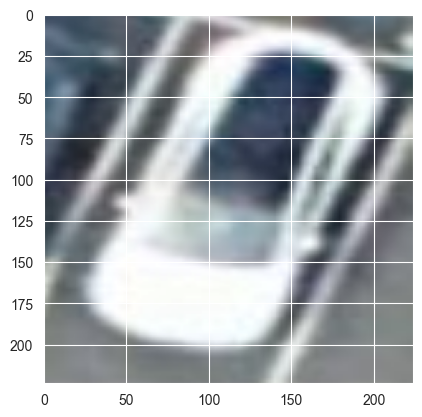

In [218]:
pix = np.asarray(ToPILImage('RGB')(img))
pix = pix.reshape((224,224,3))
plt.imshow(pix)


In [225]:
pix

array([[[ 58,  74,  95],
        [ 58,  74,  95],
        [ 58,  74,  95],
        ...,
        [131, 139, 142],
        [134, 142, 145],
        [134, 142, 145]],

       [[ 60,  75,  96],
        [ 60,  75,  96],
        [ 60,  75,  96],
        ...,
        [128, 136, 139],
        [131, 139, 142],
        [131, 139, 142]],

       [[ 60,  76,  97],
        [ 60,  76,  97],
        [ 60,  76,  97],
        ...,
        [119, 127, 130],
        [122, 130, 132],
        [122, 130, 132]],

       ...,

       [[132, 135, 135],
        [132, 135, 135],
        [132, 135, 135],
        ...,
        [132, 134, 133],
        [132, 134, 133],
        [132, 134, 133]],

       [[134, 135, 137],
        [134, 135, 137],
        [134, 135, 137],
        ...,
        [132, 134, 133],
        [132, 134, 133],
        [132, 134, 133]],

       [[134, 135, 137],
        [134, 135, 137],
        [134, 135, 137],
        ...,
        [132, 134, 133],
        [132, 134, 133],
        [132, 134, 133]]

In [214]:
display_images(hits, num_images=5)
display_images(false_alarms, num_images=5)
display_images(misses, num_images=5)
display_images(correct_rejections, num_images=5)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [126]:
ds["test"][int(hits.index[i])]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=99x83>,
 'label': 1,
 'task_text': 'car. tesla car',
 'idx': 869,
 'pixel_values': tensor([[[-0.1828, -0.1828, -0.1657,  ..., -1.7069, -1.6898, -1.6898],
          [-0.1828, -0.1828, -0.1657,  ..., -1.7069, -1.6898, -1.6898],
          [-0.1999, -0.1999, -0.1828,  ..., -1.6898, -1.6727, -1.6727],
          ...,
          [-0.9363, -0.9877, -1.1075,  ...,  1.3413,  1.1529,  1.1015],
          [-0.8507, -0.9020, -1.0219,  ...,  1.6153,  1.4440,  1.3927],
          [-0.8335, -0.8849, -1.0048,  ...,  1.6495,  1.4954,  1.4440]],
 
         [[ 0.0826,  0.0826,  0.1001,  ..., -1.5630, -1.5455, -1.5455],
          [ 0.0826,  0.0826,  0.1001,  ..., -1.5630, -1.5455, -1.5455],
          [ 0.0651,  0.0651,  0.0826,  ..., -1.5280, -1.5280, -1.5280],
          ...,
          [-0.7402, -0.7927, -0.9153,  ...,  1.4482,  1.2556,  1.2031],
          [-0.6527, -0.7052, -0.8277,  ...,  1.7283,  1.5532,  1.5007],
          [-0.6352, -0.6877,

In [349]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# calculate f1 score precision and recall for the model
f1 = f1_score(pred['labels'], pred['predictions'])
precision = precision_score(pred['labels'], pred['predictions'])
recall = recall_score(pred['labels'], pred['predictions'])
accuracy_metric = accuracy_score(pred['labels'], pred['predictions'])
print('f1 score:' + str(f1) +' precision: ' + str(precision) + ' recall: ' + str(recall) + ' accuracy: ' + str(accuracy_metric))

f1 score:0.8085106382978723 precision: 0.9047619047619048 recall: 0.7307692307692307 accuracy: 0.9666666666666667


In [122]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         3.0
  total_flos               = 136184864GF
  train_loss               =      0.3607
  train_runtime            =  0:01:46.39
  train_samples_per_second =      17.735
  train_steps_per_second   =       0.282


In [123]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.8593
  eval_loss               =     0.4046
  eval_runtime            = 0:00:05.13
  eval_samples_per_second =     52.543
  eval_steps_per_second   =      3.308


In [17]:
example = ds[0]
inputs = processor(images=example['pixel_values'], text=example['task_text'], return_tensors="pt").to(device)

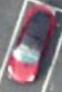

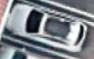

In [201]:
example['image']

In [18]:
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

In [19]:
outputs

GroundingDinoObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-2.9577, -1.2911, -3.7883,  ...,    -inf,    -inf,    -inf],
         [-3.4443, -1.6889, -4.4113,  ...,    -inf,    -inf,    -inf],
         [-4.4644, -3.5197, -5.3438,  ...,    -inf,    -inf,    -inf],
         ...,
         [-5.6200, -4.6275, -6.4708,  ...,    -inf,    -inf,    -inf],
         [-6.0711, -5.3053, -7.0361,  ...,    -inf,    -inf,    -inf],
         [-5.7230, -4.7064, -6.6358,  ...,    -inf,    -inf,    -inf]]],
       device='mps:0'), pred_boxes=tensor([[[4.9975e-01, 4.9959e-01, 1.0000e+00, 1.0000e+00],
         [5.0392e-01, 4.6696e-01, 8.1556e-01, 9.0890e-01],
         [5.0750e-01, 4.7119e-01, 8.1983e-01, 8.9996e-01],
         ...,
         [4.9006e-02, 4.9847e-01, 9.8231e-02, 9.9869e-01],
         [4.9833e-01, 9.9982e-01, 9.9996e-01, 8.2453e-04],
         [3.6546e-01, 3.7226e-01, 7.2898e-01, 7.5013e-01]]], device='mps:0'), auxiliary_outputs=None, last_hidden_state=tensor([[[-0.1992, -0.266

In [229]:
nh

torch.Size([1, 21260, 8, 4, 4])

In [221]:
img_hidden_states = torchvision.transforms.ToPILImage()(outputs.encoder_attentions[-1])

In [236]:
import matplotlib.pyplot as plt

# Run the model and get the attention weights
inputs = processor(images=example['image'], text=example['task_text'], return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

outputs

GroundingDinoObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-2.8274, -1.2265, -3.9239,  ...,    -inf,    -inf,    -inf],
         [-3.8435, -2.3759, -5.1854,  ...,    -inf,    -inf,    -inf],
         [-4.7557, -3.7140, -5.9557,  ...,    -inf,    -inf,    -inf],
         ...,
         [-5.8837, -4.6818, -7.0443,  ...,    -inf,    -inf,    -inf],
         [-5.4654, -4.1490, -6.5993,  ...,    -inf,    -inf,    -inf],
         [-5.3751, -4.6265, -6.5485,  ...,    -inf,    -inf,    -inf]]],
       device='mps:0'), pred_boxes=tensor([[[0.4998, 0.4992, 1.0000, 1.0000],
         [0.6090, 0.4638, 0.2779, 0.3769],
         [0.6087, 0.4649, 0.2749, 0.3772],
         ...,
         [0.2664, 0.8096, 0.5324, 0.3811],
         [0.0176, 0.0203, 0.0351, 0.0402],
         [0.6266, 0.2009, 0.7417, 0.4040]]], device='mps:0'), auxiliary_outputs=None, last_hidden_state=tensor([[[-2.2715e-01, -2.6905e-01,  5.1241e-02,  ..., -2.1885e-04,
          -4.0083e-01, -4.1653e-01],
         [-1.004

In [21]:
results = processor.post_process_grounded_object_detection(outputs, inputs.input_ids, box_threshold=0.15, text_threshold=0.1, target_sizes=[example['pixel_values'].size[::-1]])

In [22]:
results

[{'scores': tensor([0.2157, 0.1559], device='mps:0'),
  'labels': ['car car', 'car'],
  'boxes': tensor([[-1.5344e-02, -3.7368e-02,  6.1985e+01,  9.1962e+01],
          [ 5.9605e+00,  1.1511e+00,  5.6525e+01,  8.4770e+01]], device='mps:0')}]

In [23]:

train_size = 0.6
test_size = 0.1
val_size = 0.3
num_samples = len(dataset)

indices = np.arange(num_samples)
train_indices, test_val_indices = train_test_split(indices, test_size=test_size+val_size, random_state=random_seed)
test_val_indices = np.array(test_val_indices)
test_indices, val_indices = train_test_split(test_val_indices, test_size=val_size/(test_size+val_size), random_state=random_seed)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

NameError: name 'dataset' is not defined

In [80]:
# Define the dataloaders
batch_size = 15
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [81]:
[x for x in train_dataloader]

RuntimeError: stack expects each tensor to be equal size, but got [3, 725, 1333] at entry 0 and [3, 1332, 742] at entry 1

In [82]:

# Step 2: Freeze the pre-trained GroundingDino model's parameters
for param in model.parameters():
    param.requires_grad = False

# Step 3: Replace the last layer(s) of the model
# The exact code for this step will depend on the architecture of the model
# Here's an example for a model with a single linear layer at the end
num_classes = 2  # Tesla and non-Tesla
model.class_embed = nn.ModuleList([nn.Linear(256, num_classes) for _ in range(6)])

# Step 4: Train the model on the new dataset
# This will involve creating a DataLoader for your dataset, defining a loss function and an optimizer, and writing a training loop
# Here's a very basic example:

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

# Step 5: (Optional) Fine-tune the model
# If you decide to fine-tune the model, you would unfreeze some or all of the pre-trained model's layers and continue training
# Here's how you can unfreeze all layers:

for param in model.parameters():
    param.requires_grad = True


RuntimeError: stack expects each tensor to be equal size, but got [3, 1318, 800] at entry 0 and [3, 1333, 792] at entry 1

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

# Create the dataset
dataset = CarDataset(data_labels, cropped_images_folder, transform=transform)

In [30]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)